# 1. Preliminaries

## 1.1. Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import time

## 1.2. Define auxiliary functions

In [2]:
def logdet(M):
    slogdet_M = la.slogdet(M)
    return slogdet_M[0]*slogdet_M[1]

def LSE(x):
    n = len(x)
    f = 0
    for i in range(n):
        f += np.exp(x[i])
    return np.log(f)

def LSE_max(x):
    y = x-max(x)
    return LSE(y)+max(x)

## 1.3. Set parameters

In [3]:
# set start date
start = 15

# set holding period
H = 14

# set lag for momentum 
L = 14

# set number of quantiles
Q = 5

# 2. Size and momentum factors

## 2.1. Read in data

In [4]:
# get cryptocurrency returns
price_df = pd.read_csv(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\price.csv")
price = price_df.iloc[:,1:].to_numpy()
returns = np.zeros((price.shape[0]-start,price.shape[1]))
for t in range(start,price.shape[0]):
    for i in range(price.shape[1]):
        returns[t-start,i] = 100*((price[t,i]/price[t-1,i])-1)
        
# get risk-free interest rates
rfrate_df = pd.read_csv(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\rfrate.csv")
r_f = rfrate_df.iloc[start:,1].to_numpy()
    
# get market capitalizations
mktcap_df = pd.read_csv(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\mktcap.csv")
mktcap_0 = mktcap_df.iloc[start-1,1:].to_numpy()
mktcap = mktcap_df.iloc[start:,1:].to_numpy()

# get size factor
size = mktcap
size_0 = mktcap_0

# get momentum factor
momentum = np.zeros((price.shape[0]-start,price.shape[1]))
for t in range(start,price.shape[0]):
    for i in range(price.shape[1]):
        prior_returns = np.zeros(L)
        for l in range(L):
            prior_returns[l] = 100*((price[t-L+l,i]/price[t-L,i])-1)
        momentum[t-start,i] = np.mean(prior_returns)
momentum_0 = momentum[0,:]

## 2.2. Set dimensions

In [5]:
T = returns.shape[0]
N = returns.shape[1]

## 2.3. Compute factors

### 2.3.1. Portfolio return functions

In [6]:
def get_quantile_portfolio_returns(Q,returns,mktcap,factor,flip=0):
    T = returns.shape[0]
    N = returns.shape[1]
    quantile_break = int(N/Q)
    quantile_portolio_returns = np.zeros((T,Q))
    for t in range(T):
        if flip == 0:
            sorted_factor_idx = np.flip(np.argsort(factor[t,:]))
        else:
            sorted_factor_idx = np.argsort(factor[t,:])
        for q in range(Q):
            portfolio_idx = sorted_factor_idx[(q*quantile_break):((q+1)*quantile_break)]
            portfolio_mktcap = np.sum(mktcap[t,portfolio_idx])
            for i in range(len(portfolio_idx)):
                quantile_portolio_returns[t,q] += returns[t,portfolio_idx[i]]*(mktcap[t,portfolio_idx[i]]/portfolio_mktcap)
    return quantile_portolio_returns

def get_quantile_portfolio_returns_hold(H,Q,returns,mktcap,mktcap_0,factor,factor_0,flip=0):
    T = returns.shape[0]
    N = returns.shape[1]
    quantile_break = int(N/Q)
    quantile_portolio_returns = np.zeros((T,Q))
    sorted_factor_idx = np.zeros(N)
    T_hold = 0
    if flip == 0:
        sorted_factor_idx = np.flip(np.argsort(factor_0))
    else:
        sorted_factor_idx = np.argsort(factor_0)
    for t in range(T):
        for q in range(Q):
            if T_hold == 0:
                if q == (Q-1):
                    portfolio_idx = sorted_factor_idx[(q*quantile_break):N]
                    portfolio_mktcap = np.sum(mktcap_0[portfolio_idx])
                    for i in range(len(portfolio_idx)):
                        quantile_portolio_returns[t,q] += returns[t,portfolio_idx[i]]*(mktcap_0[portfolio_idx[i]]/portfolio_mktcap)
                else:
                    portfolio_idx = sorted_factor_idx[(q*quantile_break):((q+1)*quantile_break)]
                    portfolio_mktcap = np.sum(mktcap_0[portfolio_idx])
                    for i in range(len(portfolio_idx)):
                        quantile_portolio_returns[t,q] += returns[t,portfolio_idx[i]]*(mktcap_0[portfolio_idx[i]]/portfolio_mktcap)
            else:
                if q == (Q-1):
                    portfolio_idx = sorted_factor_idx[(q*quantile_break):N]
                    portfolio_mktcap = np.sum(mktcap[T_hold,portfolio_idx])
                    for i in range(len(portfolio_idx)):
                        quantile_portolio_returns[t,q] += returns[t,portfolio_idx[i]]*(mktcap[T_hold,portfolio_idx[i]]/portfolio_mktcap)
                else:
                    portfolio_idx = sorted_factor_idx[(q*quantile_break):((q+1)*quantile_break)]
                    portfolio_mktcap = np.sum(mktcap[T_hold,portfolio_idx])
                    for i in range(len(portfolio_idx)):
                        quantile_portolio_returns[t,q] += returns[t,portfolio_idx[i]]*(mktcap[T_hold,portfolio_idx[i]]/portfolio_mktcap)
        if t%H == (H-1):
            T_hold = t
            if flip == 0:
                sorted_factor_idx = np.flip(np.argsort(factor[t,:]))
            else:
                sorted_factor_idx = np.argsort(factor[t,:])
    return quantile_portolio_returns

def get_highlow_portfolio_returns(Q,quantile_portfolio_returns):
    T = quantile_portfolio_returns.shape[0]
    N = quantile_portfolio_returns.shape[1]
    highlow_portfolio_returns = np.zeros(T)
    for t in range(T):
        highlow_portfolio_returns[t] = quantile_portfolio_returns[t,(1-1)]-quantile_portfolio_returns[t,(Q-1)]
    return highlow_portfolio_returns

def get_factor_portfolio_returns(H,returns,mktcap,mktcap_0,factor,factor_0):
    T = returns.shape[0]
    N = returns.shape[1]
    S_break = np.array([0,20,100])
    F_break = np.array([0,30,70,100])
    portfolio_returns = np.zeros((T,2,3))
    T_hold = 0
    S_sorted_idx = np.flip(np.argsort(mktcap_0))
    F_sorted_idx = np.flip(np.argsort(factor_0))
    for t in range(T):
        for s in range(2):
            for m in range(3):
                S_curr_idx = S_sorted_idx[S_break[s]:S_break[s+1]]
                F_curr_idx = F_sorted_idx[F_break[m]:F_break[m+1]]
                SF_curr_idx = np.intersect1d(S_curr_idx,F_curr_idx)
                if T_hold == 0:
                    SF_curr_mktcap = np.sum(mktcap_0[SF_curr_idx])
                    for i in range(len(SF_curr_idx)):
                        portfolio_returns[t,s,m] += returns[t,SF_curr_idx[i]]*(mktcap_0[SF_curr_idx[i]]/SF_curr_mktcap)
                else:
                    SF_curr_mktcap = np.sum(mktcap[T_hold,SF_curr_idx])
                    for i in range(len(SF_curr_idx)):
                        portfolio_returns[t,s,m] += returns[t,SF_curr_idx[i]]*(mktcap[T_hold,SF_curr_idx[i]]/SF_curr_mktcap)
        if t%H == (H-1):
            T_hold = t
            S_sorted_idx = np.flip(np.argsort(mktcap[T_hold,:]))
            F_sorted_idx = np.flip(np.argsort(factor[T_hold,:]))
    return portfolio_returns

### 2.3.2. Quantile portfolios

In [7]:
# compute market returns
r_MKT = np.zeros(T)
for t in range(T):
    total_mktcap = np.sum(mktcap[t,:])
    for i in range(N):
        r_MKT[t] += returns[t,i]*(mktcap[t,i]/total_mktcap)

# compute high/low size returns
size_qpr = get_quantile_portfolio_returns_hold(H,Q,returns,mktcap,mktcap_0,size,size_0,flip=1)
print("SIZE")
print("Mean returns:",np.mean(size_qpr,axis=0))
print("High-low paired t-test one-sided p-value:",
      st.ttest_rel(size_qpr[:,(1-1)],size_qpr[:,(Q-1)],alternative='greater').pvalue)

# compute high/low momentum returns
momentum_qpr = get_quantile_portfolio_returns_hold(H,Q,returns,mktcap,mktcap_0,momentum,momentum_0)
print("\nMOMENTUM")
print("Mean returns:",np.mean(momentum_qpr,axis=0))
print("High-low paired t-test one-sided p-value:",
      st.ttest_rel(momentum_qpr[:,(1-1)],momentum_qpr[:,(Q-1)],alternative='greater').pvalue)

SIZE
Mean returns: [1.23809193 0.9302853  0.68660676 0.75227116 0.47891348]
High-low paired t-test one-sided p-value: 5.999409060611356e-07

MOMENTUM
Mean returns: [0.81210677 0.92259447 0.53200601 0.42266997 0.40808018]
High-low paired t-test one-sided p-value: 0.03128845900365908


### 2.3.3. Size-factor portfolios

In [8]:
factor_portfolio_returns = get_factor_portfolio_returns(H,returns,mktcap,mktcap_0,momentum,momentum_0)
r_BW = factor_portfolio_returns[:,0,0]
r_BM = factor_portfolio_returns[:,0,1]
r_BL = factor_portfolio_returns[:,0,2]
r_SW = factor_portfolio_returns[:,1,0]
r_SM = factor_portfolio_returns[:,1,1]
r_SL = factor_portfolio_returns[:,1,2]
r_SMB = np.zeros(T)
r_WML = np.zeros(T)
for t in range(T):
    r_SMB[t] = ((r_SW[t]+r_SM[t]+r_SL[t])/3)-((r_BW[t]+r_BM[t]+r_BL[t])/3)
    r_WML[t] = ((r_BW[t]+r_SW[t])/2)-((r_BL[t]+r_SL[t])/2)
    
print("SIZE X MOMENTUM:")
print(np.array([[np.mean(r_BW),np.mean(r_BM),np.mean(r_BL)],
                [np.mean(r_SW),np.mean(r_SM),np.mean(r_SL)]]))

print("\nW:",st.ttest_rel(r_BW,r_SW,alternative='less'))
print("M:",st.ttest_rel(r_BM,r_SM,alternative='less'))
print("L:",st.ttest_rel(r_BL,r_SL,alternative='less'))
print("B:",st.ttest_rel(r_BW,r_BL,alternative='greater'))
print("S:",st.ttest_rel(r_SW,r_SL,alternative='greater'))

print("\n(MKT-RF,SMB,WML) Covariance Matrix:")
print(np.corrcoef(np.array([r_MKT-r_f,r_SMB,r_WML])))

print("\n((MKT-RF)^2,SMB^2,WML^2) Covariance Matrix:")
print(np.corrcoef(np.array([(r_MKT-r_f)**2,r_SMB**2,r_WML**2])))

SIZE X MOMENTUM:
[[0.79886929 0.49355541 0.35605894]
 [0.82736388 0.75673501 0.76551202]]

W: Ttest_relResult(statistic=-0.1505161278604827, pvalue=0.440215814629089)
M: Ttest_relResult(statistic=-1.8525135947220932, pvalue=0.03233617187015167)
L: Ttest_relResult(statistic=-2.2981049024128106, pvalue=0.011029820307963808)
B: Ttest_relResult(statistic=1.8426000088196561, pvalue=0.03305549844745086)
S: Ttest_relResult(statistic=0.40712372733344016, pvalue=0.3420650499282707)

(MKT-RF,SMB,WML) Covariance Matrix:
[[ 1.          0.0511404   0.00993393]
 [ 0.0511404   1.         -0.17037178]
 [ 0.00993393 -0.17037178  1.        ]]

((MKT-RF)^2,SMB^2,WML^2) Covariance Matrix:
[[1.         0.13694271 0.10569204]
 [0.13694271 1.         0.34236197]
 [0.10569204 0.34236197 1.        ]]


## 2.4. CAPM

In [9]:
# fit CAPM
alpha_CAPM = np.zeros(N)
b_MKT_CAPM = np.zeros(N)
R2adj_CAPM = np.zeros(N)
sigma_CAPM = np.zeros(N)
for i in range(N):
    y = returns[:,i]-r_f
    X = np.column_stack((np.ones(T),r_MKT-r_f))
    mod = sm.OLS(y,X)
    res = mod.fit()
    alpha_CAPM[i] = np.abs(res.params[0])
    b_MKT_CAPM[i] = res.params[1]
    R2adj_CAPM[i] = res.rsquared_adj
    sigma_CAPM[i] = la.norm(y-mod.predict(res.params,X))/np.sqrt(T)

# show average alpha and R2adj
print(np.mean(alpha_CAPM))
print(np.mean(R2adj_CAPM))
print(np.mean(sigma_CAPM))

0.33330386527704114
0.37827474947088974
6.665256977905166


## 2.5. C3FM

In [10]:
# fit C3FM
alpha_C3FM = np.zeros(N)
b_MKT_C3FM = np.zeros(N)
b_SMB_C3FM = np.zeros(N)
b_WML_C3FM = np.zeros(N)
p_MKT_C3FM = np.zeros(N)
p_SMB_C3FM = np.zeros(N)
p_WML_C3FM = np.zeros(N)
R2adj_C3FM = np.zeros(N)
sigma_C3FM = np.zeros(N)
for i in range(N):
    y = returns[:,i]-r_f
    X = np.column_stack((np.ones(T),r_MKT-r_f,r_SMB,r_WML))
    mod = sm.OLS(y,X)
    res = mod.fit()
    alpha_C3FM[i] = np.abs(res.params[0])
    b_MKT_C3FM[i] = res.params[1]
    b_SMB_C3FM[i] = res.params[2]
    b_WML_C3FM[i] = res.params[3]
    p_MKT_C3FM[i] = res.pvalues[1]
    p_SMB_C3FM[i] = res.pvalues[2]
    p_WML_C3FM[i] = res.pvalues[3]
    R2adj_C3FM[i] = res.rsquared_adj
    sigma_C3FM[i] = la.norm(y-mod.predict(res.params,X))/np.sqrt(T)

# show average alpha and R2adj
print(np.mean(alpha_C3FM))
print(np.mean(R2adj_C3FM))
print(np.mean(sigma_C3FM))

0.29601177754528046
0.40974710913077667
6.477662871643309


## 2.7. Compare CAPM and C3FM

In [11]:
print(st.ttest_rel(alpha_CAPM,alpha_C3FM,alternative='greater'))
print(st.ttest_rel(R2adj_CAPM,R2adj_C3FM,alternative='less'))
print(st.ttest_rel(sigma_CAPM,sigma_C3FM))

Ttest_relResult(statistic=2.8293372308098195, pvalue=0.002823824244505313)
Ttest_relResult(statistic=-13.075250512601306, pvalue=1.358903989585212e-23)
Ttest_relResult(statistic=13.975551332680073, pvalue=3.694564530012872e-25)


# 3. Fit RSFM

## 3.1. EM algorithm

In [12]:
class rsfm_fit_inf():
    
    def __init__(self,likelihood,prediction,filtering,smoothing):
        self.likelihood = likelihood
        self.prediction = prediction
        self.filtering = filtering
        self.smoothing = smoothing

class rsfm_fit_out():
    
    def __init__(self,α,B,σ,p,P,observed,PLL_hist,OLL_hist,AIC,BIC):
        self.α = α
        self.B = B
        self.σ = σ
        self.p = p
        self.P = P
        self.observed = observed
        self.PLL_hist = PLL_hist
        self.OLL_hist = OLL_hist
        self.AIC = AIC
        self.BIC = BIC
        
    def inference(self):
        
        # create matrices to store probabilities
        T = self.observed.shape[0]
        S = self.observed.shape[1]
        likelihood = self.observed
        prediction = np.zeros((T+1,S))
        filtering = np.zeros((T,S))
        smoothing = np.zeros((T,S)) 

        # compute prediction and filtering probabilities
        prediction[0,:] = self.p
        for t in range(T):
            # compute total for filtering
            log_prediction_likelihood = np.zeros(S)
            for s in range(S):
                log_prediction_likelihood[s] = np.log(max(prediction[t,s],1e-100))+likelihood[t,s]
            log_prediction_total = LSE_max(log_prediction_likelihood)
            # compute filtering
            for s in range(S):
                filtering[t,s] = np.exp(np.log(max(prediction[t,s],1e-100))+likelihood[t,s]-log_prediction_total)
            # compute prediction
            for s in range(S):
                for sprime in range(S):
                    prediction[t+1,s] += filtering[t,sprime]*self.P[sprime,s]

        # compute smoothing probabilities
        for t in range(T-1,0-1,-1):
            for s in range(S):
                for sprime in range(S):
                    if t == T-1:
                        smoothing[t,s] += self.P[s,sprime]*prediction[t+1,sprime]/prediction[t+1,sprime]
                    else:
                        smoothing[t,s] += self.P[s,sprime]*smoothing[t+1,sprime]/prediction[t+1,sprime]
                smoothing[t,s] = smoothing[t,s]*filtering[t,s]
        
        return rsfm_fit_inf(likelihood,prediction,filtering,smoothing)
        

def rsfm_fit(R,F,S,N_ITER,N_INIT,seed=0,verbose=2,init_noise_scale=np.array([0.5,0.5,5])):
    
    ## INITIALIZATION ###
    
    # set seed and dimensions
    np.random.seed(seed)
    T = R.shape[0]
    N = R.shape[1]
    M = F.shape[1]
    
    # record best estimates
    α_best = np.zeros((S,N))
    B_best = np.ones((S,N,M))
    σ_best = np.ones((S,N,M))
    p_best = np.ones(S)/S
    P_best = np.ones((S,S))/S**2
    observed_best = np.zeros((T,S))
    PLL_hist_best = np.zeros(N_ITER)
    OLL_hist_best = np.zeros(N_ITER)
    OLL_best = -np.inf

    ### ESTIMATE PARAMETERS ###
    
    for init in range(N_INIT):
        
        time_init_0 = time.time()
        
        # randomly initialize factor model parameters
        α = np.zeros((S,N))+np.reshape(np.random.normal(loc=0,scale=init_noise_scale[0],size=S*N),(S,N))
        B = np.ones((S,N,M))+np.reshape(np.random.normal(loc=0,scale=init_noise_scale[1],size=S*N*M),(S,N,M))
        σ = np.reshape(np.random.chisquare(df=init_noise_scale[2],size=S*N),(S,N))
        
        # randomly initialize Markov chain parameters
        p = np.random.rand(S)
        p = p/np.sum(p)
        P = np.random.rand(S,S)
        for s in range(S):
            P[s,:] = P[s,:]/np.sum(P[s,:])
            
        # create likelihood histories
        PLL_hist = np.zeros(N_ITER)
        OLL_hist = np.zeros(N_ITER)
            
        # iterative updates
        for n in range(N_ITER):
            
            time_iter_0 = time.time()
            
            try:    
                    
                ### EXPECTATION STEP ###
                
                # compute observed log-densities
                observed = np.zeros((T,S))
                for s in range(S):
                    α_s = α[s,:]
                    B_s = B[s,:,:]
                    σ_s = σ[s,:]
                    Ω_s = np.diag(σ[s,:]**2)
                    for t in range(T):
                        e_st = returns[t,:]-r_f[t]-α_s-B_s@F[t,:]
                        observed[t,s] = -0.5*N*np.log(2*np.pi)-0.5*logdet(Ω_s)-0.5*e_st@la.inv(Ω_s)@e_st
                
                # compute forward log-densities
                forward = np.zeros((T,S))
                for s in range(S):
                    forward[0,s] = np.log(max(p[s],1e-100))+observed[0,s]
                for t in range(1,T):
                    for s in range(S):
                        log_forward_iterate = np.zeros(S)
                        for sprime in range(S):
                            log_forward_iterate[sprime] = forward[t-1,sprime]+np.log(max(P[sprime,s],1e-100))+observed[t,s]
                        forward[t,s] = LSE_max(log_forward_iterate)

                # compute backward log-densities
                backward = np.zeros((T,S))
                for t in range(T-2,0-1,-1):
                    for s in range(S):
                        log_backward_iterate = np.zeros(S)
                        for sprime in range(S):
                            log_backward_iterate[sprime] = backward[t+1,sprime]+np.log(max(P[s,sprime],1e-100))+observed[t+1,sprime]
                        backward[t,s] = LSE_max(log_backward_iterate) 

                # compute posterior marginal log-probabilities for latent variables
                marginal = np.zeros((T,S))
                for t in range(T):
                    for s in range(S):
                        log_marginal_total = np.zeros(S)
                        for sprime in range(S):
                            log_marginal_total[sprime] = forward[t,sprime]+backward[t,sprime]
                        marginal[t,s] = forward[t,s]+backward[t,s]-LSE_max(log_marginal_total)

                # compute posterior transition log-probabilities for latend variables
                transition = np.zeros((T-1,S,S))
                for t in range(T-1):
                    for s in range(S):
                        for sprime in range(S):
                            log_transition_total = np.zeros((S,S))
                            for j in range(S):
                                for k in range(S):
                                    log_transition_total[j,k] = forward[t,j]+np.log(max(P[j,k],100))+backward[t+1,k]+observed[t+1,k]
                            log_transition_total = log_transition_total.flatten()
                            transition[t,s,sprime] = forward[t,s]+np.log(max(P[s,sprime],100))+backward[t+1,sprime]+observed[t+1,sprime]-LSE_max(log_transition_total)
                
                ### MAXIMIZATION STEP (FACTOR MODEL) ###

                # create new iterates
                α_new = np.zeros((S,N))
                B_new = np.ones((S,N,M))
                σ_new = np.ones((S,N))
                    
                # compute new iterates
                latent_posterior = np.exp(marginal)
                for s in range(S):
                    # compute total for smoothing
                    total_latent_posterior = 0
                    for t in range(T):
                        total_latent_posterior += latent_posterior[t,s]
                    # create state-dependent factor matrix
                    F_tilde_s = np.zeros((T,M+1))
                    for t in range(T):
                        for m in range(M+1):
                            if m == 0:
                                F_tilde_s[t,m] = latent_posterior[t,s]**0.5
                            else:
                                F_tilde_s[t,m] = latent_posterior[t,s]**0.5*F[t,m-1]
                    for i in range(N):
                        # create state-dependent returns on asset i
                        r_tilde_is = np.zeros(T)
                        for t in range(T):
                            r_tilde_is[t] = latent_posterior[t,s]**0.5*R[t,i]
                        # compute factor model parameters  
                        β_is = la.inv(np.transpose(F_tilde_s)@F_tilde_s)@np.transpose(F_tilde_s)@r_tilde_is
                        σ_is = la.norm(r_tilde_is-F_tilde_s@β_is)/(total_latent_posterior**0.5)
                        α_new[s,i] = β_is[0]
                        B_new[s,i,:] = β_is[1:]
                        σ_new[s,i] = σ_is

                ### MAXIMIZATION STEP (MARKOV CHAIN) ###

                # compute new iterates
                p_new = latent_posterior[0,:]
                P_new = np.zeros((S,S))
                for s in range(S):
                    for sprime in range(S):
                        num = 0
                        dnm = 0
                        for t in range(T-1):
                            num += np.exp(transition[t,s,sprime])
                            dnm += np.exp(marginal[t,s])
                        P_new[s,sprime] = num/dnm

                ### UPDATE PARAMETERS ###
                
                # update parameters
                α = α_new
                B = B_new
                σ = σ_new
                p = p_new
                P = P_new
                
                # update average posterior log-likelihood
                for t in range(T):
                    PLL_state = np.zeros(S)
                    for s in range(S):
                        PLL_state[s] = np.log(max(latent_posterior[t,s],1e-100))+observed[t,s]
                    PLL_total = LSE_max(PLL_state) 
                    PLL_hist[n] += PLL_total/T

                # update average observed log-likelihood
                for t in range(T):
                    latent_marginal = la.matrix_power(np.transpose(P),t)@p
                    OLL_state = np.zeros(S)
                    for s in range(S):
                        OLL_state[s] = np.log(max(latent_marginal[s],1e-100))+observed[t,s]
                    OLL_total = LSE_max(OLL_state)
                    OLL_hist[n] += OLL_total/T

                time_iter_1 = time.time()
                if verbose >= 2:
                    print("init ",init+1,"/",N_INIT,", iter ",n+1,"/",N_ITER," --- ",time_iter_1-time_iter_0," seconds",sep="")
                    
            except la.LinAlgError:
                OLL_hist[-1] = -np.inf
                
        ### EVALUATE MODEL ###
        
        if OLL_hist[-1] >= OLL_best:
            α_best = α
            B_best = B
            σ_best = σ
            p_best = p
            P_best = P
            observed_best = observed
            PLL_hist_best = PLL_hist
            OLL_hist_best = OLL_hist
            OLL_best = OLL_hist[-1]
            if verbose >= 1:
                print("better init found with log-likelihood",OLL_best)
        
        time_init_1 = time.time()
        if verbose >= 1:
            print("init ",init+1,"/",N_INIT," --- ",time_init_1-time_init_0," seconds\n",sep="")
         
    ### EVALUATE BEST MODEL ###
    
    AIC_best = -2*T*OLL_best+2*(S*N+S*N+S*N*M+S*S-1)
    BIC_best = -2*T*OLL_best+np.log(T)*(S*N+S*N+S*N*M+S*S-1)
    
    return rsfm_fit_out(α_best,B_best,σ_best,p_best,P_best,observed_best,PLL_hist_best,OLL_hist_best,AIC_best,BIC_best)

## 3.2. Vary number of states

In [13]:
S_max = 5
S_grid = np.arange(1,S_max+1)
PLL_grid = np.zeros(S_max)
OLL_grid = np.zeros(S_max)
AIC_grid = np.zeros(S_max)
BIC_grid = np.zeros(S_max)

R = np.zeros((T,N))
for t in range(T):
    R[t,:] = returns[t,:]-r_f[t]
F = np.column_stack((r_MKT-r_f,r_SMB,r_WML))

for S in S_grid:
    if S == 1:
        N_ITER = 2
        N_INIT = 1
        rsfm = rsfm_fit(R,F,S,N_ITER,N_INIT,verbose=0)
    else:
        N_ITER = 50
        N_INIT = 10
        rsfm = rsfm_fit(R,F,S,N_ITER,N_INIT,verbose=0)
    PLL_grid[S-1] = rsfm.PLL_hist[-1]
    OLL_grid[S-1] = rsfm.OLL_hist[-1]
    AIC_grid[S-1] = rsfm.AIC
    BIC_grid[S-1] = rsfm.BIC

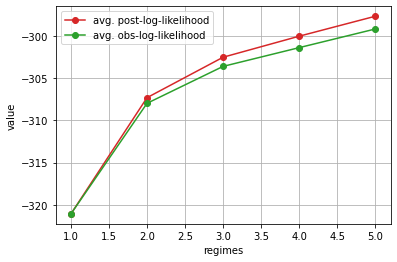

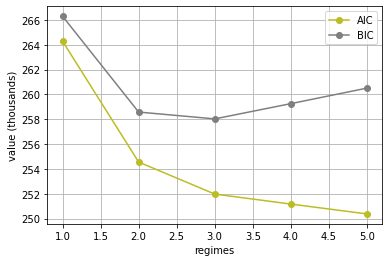

AIC: [264294.62680796 254553.85982431 251974.74519256 251167.45111029
 250373.81069934]
BIC: [266302.70538781 258582.06545549 258031.11018938 259260.00778708
 260510.59137042]


In [14]:
plt.plot(S_grid,PLL_grid,marker='o',color='C3',label='avg. post-log-likelihood')
plt.plot(S_grid,OLL_grid,marker='o',color='C2',label='avg. obs-log-likelihood')
plt.xlabel("regimes")
plt.ylabel("value")
plt.legend()
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\LL.png")
plt.show()

plt.plot(S_grid,AIC_grid/1000,marker='o',color='C8',label='AIC')
plt.plot(S_grid,BIC_grid/1000,marker='o',color='C7',label='BIC')
plt.xlabel("regimes")
plt.ylabel("value (thousands)")
plt.legend()
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\IC.png")
plt.show()

print("AIC:",AIC_grid)
print("BIC:",BIC_grid)

# 4. Analyze two-state CAPM

## 4.1. Fit model

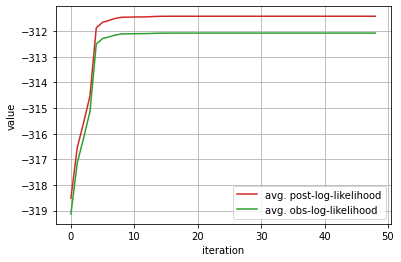

In [15]:
### SET PARAMETERS ###

# create return matrix
R = np.zeros((T,N))
for t in range(T):
    R[t,:] = returns[t,:]-r_f[t]

# create factor matrix
F = np.transpose(np.column_stack((r_MKT-r_f)))

# set number of states
S = 2

# set number of iterations
N_ITER = 50

# set number of initializations
N_INIT = 10

### RUN ALGORITHM ###

rsfm = rsfm_fit(R,F,S,N_ITER,N_INIT,verbose=0)

### PLOT LOG-LIKELIHOODS ###

plt.plot(rsfm.PLL_hist[1:],color='C3',label="avg. post-log-likelihood")
plt.plot(rsfm.OLL_hist[1:],color='C2',label="avg. obs-log-likelihood")
plt.xlabel("iteration")
plt.ylabel("value")
plt.legend()
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\hist-CAPM.png")
plt.show()

## 4.2. Smoothed inference for latent variables

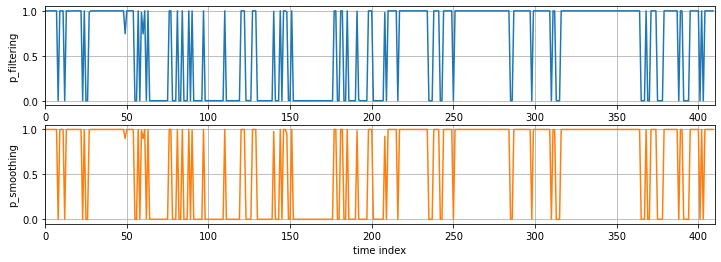

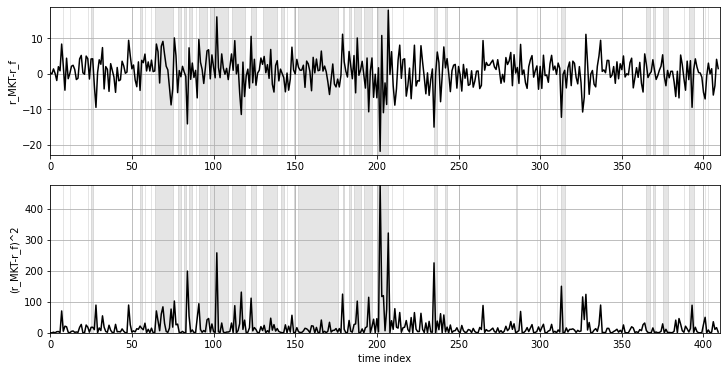

In [16]:
# assign states based on smoothing probabilities
rsfm_inf = rsfm.inference()
assigned_state = np.argmax(rsfm_inf.smoothing,axis=1)
assigned_state ^= 1
T0 = np.where(assigned_state==0)[0]
T1 = np.where(assigned_state==1)[0]

# plot prediction, filtering, and smoothing probabilities
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(1-rsfm_inf.filtering[:,0],color='C0')
plt.ylabel("p_filtering")
plt.xlim(0,T)
plt.grid()
plt.subplot(2,1,2)
plt.plot(1-rsfm_inf.smoothing[:,0],color='C1')
plt.xlabel("time index")
plt.ylabel("p_smoothing")
plt.xlim(0,T)
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\prob-CAPM.png")
plt.show()

# overlay assigned states on market factor
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(r_MKT-r_f,color='k')
plt.xlim(0,T)
plt.ylim(np.min(r_MKT-r_f)-1,np.max(r_MKT-r_f)+1)
plt.fill_between(np.arange(T),100,-100,where=assigned_state,color='k',alpha=0.1)
plt.ylabel("r_MKT-r_f")
plt.grid()
plt.subplot(2,1,2)
plt.plot((r_MKT-r_f)**2,color='k')
plt.xlim(0,T)
plt.ylim(0,np.max((r_MKT-r_f)**2)+1)
plt.fill_between(np.arange(T),1000,0,where=assigned_state,color='k',alpha=0.1)
plt.xlabel("time index")
plt.ylabel("(r_MKT-r_f)^2")
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\rmkt-CAPM.png")
plt.show()

## 4.3. Fit CAPM based on assigned state

In [17]:
# fit CAPM for state 0
alpha_CAPM_0 = np.zeros(N)
b_MKT_CAPM_0 = np.zeros(N)
R2adj_CAPM_0 = np.zeros(N)
sigma_CAPM_0 = np.zeros(N)
for i in range(N):
    y = R[T0,i]
    X = np.column_stack((np.ones(len(T0)),F[T0,:]))
    mod = sm.OLS(y,X)
    res = mod.fit()
    alpha_CAPM_0[i] = np.abs(res.params[0])
    b_MKT_CAPM_0[i] = res.params[1]
    R2adj_CAPM_0[i] = res.rsquared_adj
    sigma_CAPM_0[i] = la.norm(y-mod.predict(res.params,X))/np.sqrt(len(T0))

# show average alpha and R2adj
print("mean |α|:",np.mean(alpha_CAPM_0))
print("mean R^2:",np.mean(R2adj_CAPM_0))
print("mean  σ :",np.mean(sigma_CAPM_0))

# show t-test results
print("test |α|:",st.ttest_rel(alpha_CAPM,alpha_CAPM_0))
print("test R^2:",st.ttest_rel(R2adj_CAPM,R2adj_CAPM_0))
print("test  σ :",st.ttest_rel(sigma_CAPM,sigma_CAPM_0))

mean |α|: 0.3969614450697376
mean R^2: 0.43601851501834743
mean  σ : 4.695247298674682
test |α|: Ttest_relResult(statistic=-1.7877642324035152, pvalue=0.07687366855826376)
test R^2: Ttest_relResult(statistic=-6.391200362147584, pvalue=5.425537822020777e-09)
test  σ : Ttest_relResult(statistic=10.134496857194286, pvalue=5.5677235158449e-17)


In [18]:
# fit CAPM for state 1
alpha_CAPM_1 = np.zeros(N)
b_MKT_CAPM_1 = np.zeros(N)
R2adj_CAPM_1 = np.zeros(N)
sigma_CAPM_1 = np.zeros(N)
for i in range(N):
    y = R[T1,i]
    X = np.column_stack((np.ones(len(T1)),F[T1,:]))
    mod = sm.OLS(y,X)
    res = mod.fit()
    alpha_CAPM_1[i] = np.abs(res.params[0])
    b_MKT_CAPM_1[i] = res.params[1]
    R2adj_CAPM_1[i] = res.rsquared_adj
    sigma_CAPM_1[i] = la.norm(y-mod.predict(res.params,X))/np.sqrt(len(T1))

# show average alpha and R2adj
print("mean |α|:",np.mean(alpha_CAPM_1))
print("mean R^2:",np.mean(R2adj_CAPM_1))
print("mean  σ :",np.mean(sigma_CAPM_1))

# show t-test results
print("test |α|:",st.ttest_rel(alpha_CAPM,alpha_CAPM_1))
print("test R^2:",st.ttest_rel(R2adj_CAPM,R2adj_CAPM_1))
print("test  σ :",st.ttest_rel(sigma_CAPM,sigma_CAPM_1))

mean |α|: 0.889307281174236
mean R^2: 0.363297221413452
mean  σ : 8.699832688385317
test |α|: Ttest_relResult(statistic=-8.790499616185297, pvalue=4.726249384762102e-14)
test R^2: Ttest_relResult(statistic=3.368548839101176, pvalue=0.0010777555957084248)
test  σ : Ttest_relResult(statistic=-12.777564564594766, pvalue=1.1470420297488415e-22)


# 5. Analyze two-state C3FM

## 5.1. Fit model

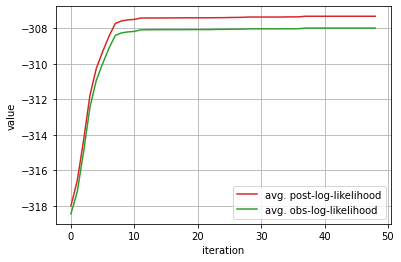

In [19]:
### SET PARAMETERS ###

# create return matrix
R = np.zeros((T,N))
for t in range(T):
    R[t,:] = returns[t,:]-r_f[t]

# create factor matrix
F = np.column_stack((r_MKT-r_f,r_SMB,r_WML))

# set number of states
S = 2

# set number of iterations
N_ITER = 50

# set number of initializations
N_INIT = 10

### RUN ALGORITHM ###

rsfm = rsfm_fit(R,F,S,N_ITER,N_INIT,verbose=0)

### PLOT LOG-LIKELIHOODS ###

plt.plot(rsfm.PLL_hist[1:],color='C3',label="avg. post-log-likelihood")
plt.plot(rsfm.OLL_hist[1:],color='C2',label="avg. obs-log-likelihood")
plt.xlabel("iteration")
plt.ylabel("value")
plt.legend()
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\hist-C3FM.png")
plt.show()

## 5.2. Smoothed inference for latent variables

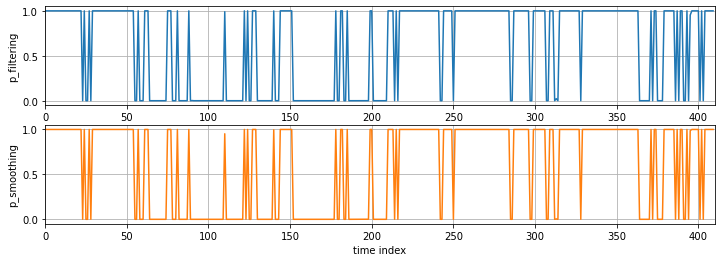

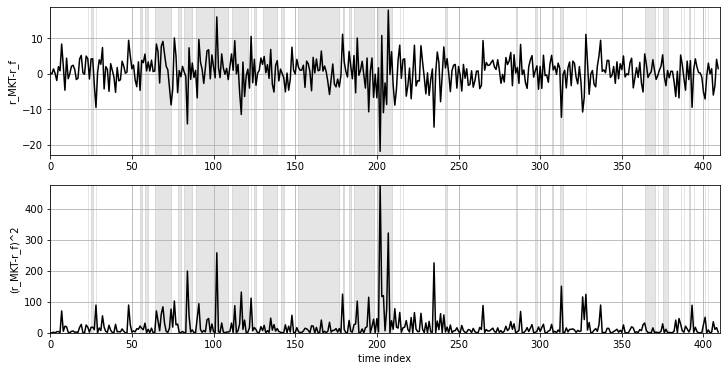

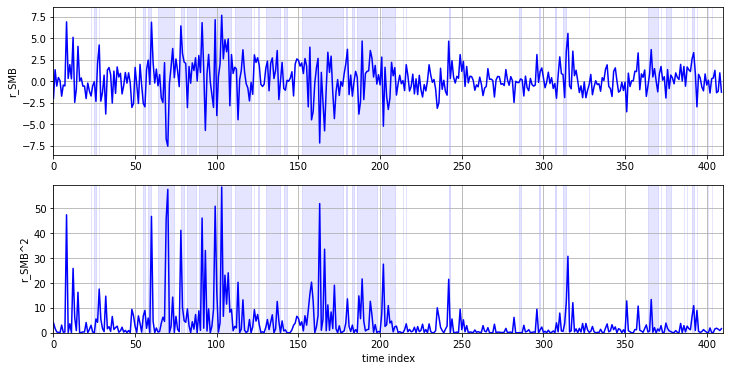

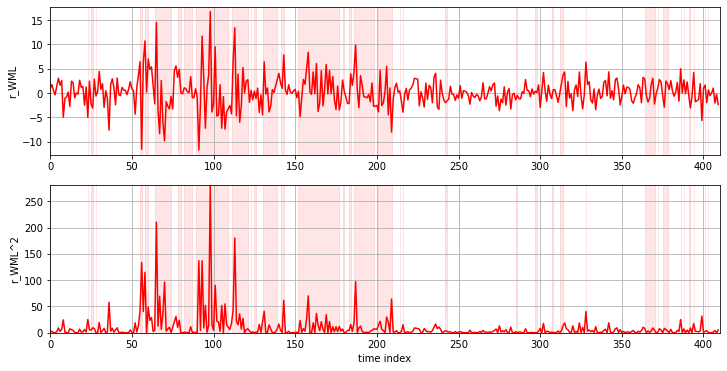

In [20]:
# assign states based on smoothing probabilities
rsfm_inf = rsfm.inference()
assigned_state = np.argmax(rsfm_inf.smoothing,axis=1)
T0 = np.where(assigned_state==0)[0]
T1 = np.where(assigned_state==1)[0]

# plot prediction, filtering, and smoothing probabilities
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(rsfm_inf.filtering[:,0],color='C0')
plt.ylabel("p_filtering")
plt.xlim(0,T)
plt.grid()
plt.subplot(2,1,2)
plt.plot(rsfm_inf.smoothing[:,0],color='C1')
plt.xlabel("time index")
plt.ylabel("p_smoothing")
plt.xlim(0,T)
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\prob-C3FM.png")
plt.show()

# overlay assigned states on market factor
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(r_MKT-r_f,color='k')
plt.xlim(0,T)
plt.ylim(np.min(r_MKT-r_f)-1,np.max(r_MKT-r_f)+1)
plt.fill_between(np.arange(T),100,-100,where=assigned_state,color='k',alpha=0.1)
plt.ylabel("r_MKT-r_f")
plt.grid()
plt.subplot(2,1,2)
plt.plot((r_MKT-r_f)**2,color='k')
plt.xlim(0,T)
plt.ylim(0,np.max((r_MKT-r_f)**2)+1)
plt.fill_between(np.arange(T),1000,0,where=assigned_state,color='k',alpha=0.1)
plt.xlabel("time index")
plt.ylabel("(r_MKT-r_f)^2")
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\rmkt-C3FM.png")
plt.show()

# overlay assigned states on size factor
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(r_SMB,color='b')
plt.xlim(0,T)
plt.ylim(np.min(r_SMB)-1,np.max(r_SMB)+1)
plt.fill_between(np.arange(T),1000,-100,where=assigned_state,color='b',alpha=0.1)
plt.ylabel("r_SMB")
plt.grid()
plt.subplot(2,1,2)
plt.plot(r_SMB**2,color='b')
plt.xlim(0,T)
plt.ylim(0,np.max(r_SMB**2)+1)
plt.fill_between(np.arange(T),10000,0,where=assigned_state,color='b',alpha=0.1)
plt.xlabel("time index")
plt.ylabel("r_SMB^2")
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\rsmb-C3FM.png")
plt.show()

# overlay assigned states on momentum factor
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(r_WML,color='r')
plt.xlim(0,T)
plt.ylim(np.min(r_WML)-1,np.max(r_WML)+1)
plt.fill_between(np.arange(T),100,-100,where=assigned_state,color='r',alpha=0.1)
plt.ylabel("r_WML")
plt.grid()
plt.subplot(2,1,2)
plt.plot(r_WML**2,color='r')
plt.xlim(0,T)
plt.ylim(0,np.max(r_WML**2)+1)
plt.fill_between(np.arange(T),10000,0,where=assigned_state,color='r',alpha=0.1)
plt.xlabel("time index")
plt.ylabel("r_WML^2")
plt.grid()
plt.savefig(r"C:\Users\zhubr\OneDrive\Desktop\ECON 492\figures\rwml-C3FM.png")
plt.show()

## 5.3. Fit C3FM based on assigned state

In [21]:
# fit C3FM for state 0
alpha_C3FM_0 = np.zeros(N)
b_MKT_C3FM_0 = np.zeros(N)
R2adj_C3FM_0 = np.zeros(N)
sigma_C3FM_0 = np.zeros(N)
for i in range(N):
    y = R[T0,i]
    X = np.column_stack((np.ones(len(T0)),F[T0,:]))
    mod = sm.OLS(y,X)
    res = mod.fit()
    alpha_C3FM_0[i] = np.abs(res.params[0])
    b_MKT_C3FM_0[i] = res.params[1]
    R2adj_C3FM_0[i] = res.rsquared_adj
    sigma_C3FM_0[i] = la.norm(y-mod.predict(res.params,X))/np.sqrt(len(T0))

# show average alpha and R2adj
print("mean |α|:",np.mean(alpha_C3FM_0))
print("mean R^2:",np.mean(R2adj_C3FM_0))
print("mean  σ :",np.mean(sigma_C3FM_0))

# show t-test results
print("test |α|:",st.ttest_rel(alpha_C3FM,alpha_C3FM_0))
print("test R^2:",st.ttest_rel(R2adj_C3FM,R2adj_C3FM_0))
print("test  σ :",st.ttest_rel(sigma_C3FM,sigma_C3FM_0))

mean |α|: 0.3826771338330659
mean R^2: 0.4799457157615787
mean  σ : 4.4276872095500766
test |α|: Ttest_relResult(statistic=-2.8851986218363748, pvalue=0.004801143018379012)
test R^2: Ttest_relResult(statistic=-7.262368499113773, pvalue=8.789660288732046e-11)
test  σ : Ttest_relResult(statistic=10.432668415565434, pvalue=1.2472627227342975e-17)


In [22]:
# fit C3FM for state 1
alpha_C3FM_1 = np.zeros(N)
b_MKT_C3FM_1 = np.zeros(N)
R2adj_C3FM_1 = np.zeros(N)
sigma_C3FM_1 = np.zeros(N)
for i in range(N):
    y = R[T1,i]
    X = np.column_stack((np.ones(len(T1)),F[T1,:]))
    mod = sm.OLS(y,X)
    res = mod.fit()
    alpha_C3FM_1[i] = np.abs(res.params[0])
    b_MKT_C3FM_1[i] = res.params[1]
    R2adj_C3FM_1[i] = res.rsquared_adj
    sigma_C3FM_1[i] = la.norm(y-mod.predict(res.params,X))/np.sqrt(len(T1))

# show average alpha and R2adj
print("mean |α|:",np.mean(alpha_C3FM_1))
print("mean R^2:",np.mean(R2adj_C3FM_1))
print("mean  σ :",np.mean(sigma_C3FM_1))

# show t-test results
print("test |α|:",st.ttest_rel(alpha_C3FM,alpha_C3FM_1))
print("test R^2:",st.ttest_rel(R2adj_C3FM,R2adj_C3FM_1))
print("test  σ :",st.ttest_rel(sigma_C3FM,sigma_C3FM_1))

mean |α|: 0.7655751193816356
mean R^2: 0.38950334676814063
mean  σ : 8.37899851213228
test |α|: Ttest_relResult(statistic=-8.397474146374316, pvalue=3.3531549945801944e-13)
test R^2: Ttest_relResult(statistic=4.2135533373542815, pvalue=5.554253280793258e-05)
test  σ : Ttest_relResult(statistic=-12.415294098382127, pvalue=6.693488214419702e-22)
